In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.stats import spearmanr
import collections
import feather
from scipy import stats
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import sys
sys.path.append('../')
import utils
import plotting


#### formatting
column 1 is yyyy_dd_hh
row 1 is generator # (s/a in the generator input file)

#### to do
1. sum each row to get the annual total per generator
2. sum the rows by state in which the generator is located
3. import egrids data
4. subtract the model output by state from the state annual emissions from egrid

#### approach
1. see if the data is linearly correlated or what the relationship is between the model/generation
2. see if a specific type of power plant is off and others are correct
3. see if a specific region of power plant is off

# Import Data

In [2]:
models = ['normal','nonuc']
pollutants = ['NO','NO2','SO2','CO2','CH4']

regionname_grouped_ds = xr.open_dataset(f'./data/regionname_grouped_emissions_ds.nc')
fueltype_grouped_ds = xr.open_dataset(f'./data/fueltype_grouped_emissions_ds.nc')
gmodel_egrid_ds = xr.open_dataset(f'./data/gmodel_egrid_emissions_ds.nc')
oris_nonuc_ds = xr.open_dataset(f'../optimization_model/outputs/oris_nonuc_ds.nc')

# Plot settings

In [3]:
###set color for each type
nonuc_color = 'C1'
normal_color = 'C0'
egrid_color = 'C7'

### set scientific names
sci_names = {'NO':r'$NO$', 'SO2':r'$SO_2$', 'NO2':r'$NO_2$', 'CO2':r'$CO_2$', 'CH4':r'$CH_4$' }

# Generator use in the no-nuclear scenario

In [4]:
###determine which regions are using a generator and when
#get list of unique region names and what generators are in which location
reg = np.unique(oris_nonuc_ds['RegionName'])
generator_oris_number = np.arange(100000,100000+len(reg))
#make a dict of region names and their associated oris number
generator_oris_dict = {generator_oris_number[idx]:f'{r}' for idx,r in enumerate(reg)} 

#make a column for generator generation in dataset
gmodel_egrid_ds['generator_generation'] = gmodel_egrid_ds['modelgeneration'].copy()
gmodel_egrid_ds['generator_generation'] = gmodel_egrid_ds['generator_generation'].where(gmodel_egrid_ds['fueltype'] == 'generator')
gmodel_egrid_ds['generator_generation'] = gmodel_egrid_ds['generator_generation'].where(gmodel_egrid_ds['generator_generation'] != 0)

#make a column for our sum of generator generation to find which ORISCodes have generators turned on
gmodel_egrid_ds['generator_generation_sum'] = gmodel_egrid_ds['generator_generation'].sum(dim='date')
ORIS_using_gen = gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation_sum'].isel(
    ORISCode = (gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation_sum'] > 0))['ORISCode'].values

#find the region in which the generator is located
reg_using_gen = generator_oris_dict[ORIS_using_gen.item()]
print('Regions using generators are ' + str(reg_using_gen))


for key, value in generator_oris_dict.items(): 
    if reg_using_gen == value: 
        ORIS_gen_code = key
        print('Region generator Oris Code is ' + str(ORIS_gen_code))

#find the times this region is using the generator
times_using_gen = gmodel_egrid_ds.sel(
    model_name = 'nonuc')['generator_generation'].sel(
    ORISCode = ORIS_gen_code).isel(
    date = (gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation'].sel(ORISCode = ORIS_using_gen.item()) > 0))['date'].values
daily_gen_use = gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation'].sel(ORISCode = ORIS_gen_code).isel(date = (gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation'].sel(ORISCode = ORIS_using_gen.item()) > 0)).values
print('\nTimes generator is used and amounts used are \n' + str(times_using_gen) + '\n' + str(daily_gen_use))

#print the total generation used
print('\nAnnual total generation produced by generators \n' + str(gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation_sum'].sum().values))

#make a dataframe with our generator information
generator_df = pd.DataFrame(data = daily_gen_use, index = times_using_gen, columns = ['Generation'])
generator_df = generator_df.rename_axis('Time')

Regions using generators are ERC_REST
Region generator Oris Code is 100002

Times generator is used and amounts used are 
['2017-05-05T05:00:00.000000000' '2017-05-05T06:00:00.000000000'
 '2017-05-05T07:00:00.000000000' '2017-05-06T05:00:00.000000000'
 '2017-05-06T06:00:00.000000000' '2017-05-06T07:00:00.000000000'
 '2017-05-07T04:00:00.000000000' '2017-05-07T05:00:00.000000000'
 '2017-05-07T06:00:00.000000000' '2017-05-07T07:00:00.000000000'
 '2017-05-07T08:00:00.000000000' '2017-05-14T05:00:00.000000000'
 '2017-05-14T06:00:00.000000000' '2017-05-14T07:00:00.000000000'
 '2017-05-23T05:00:00.000000000' '2017-05-23T06:00:00.000000000'
 '2017-05-23T07:00:00.000000000' '2017-05-25T05:00:00.000000000'
 '2017-05-25T06:00:00.000000000' '2017-05-29T06:00:00.000000000']
[ 378.8678985   960.3952985   726.65563149  696.0900261  1021.9402261
  491.53275909 1072.4838089  2261.9974985  2720.4610985  2229.53083149
  637.63643149 1353.0604985  1970.5276985  1552.57183149  804.4774449
 1305.4174449   

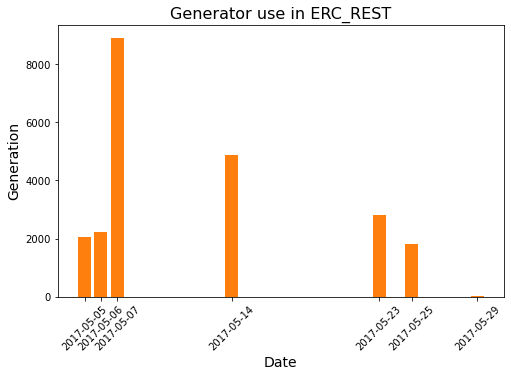

In [5]:
#### plot the generator use in this region ####
fig,ax = plt.subplots(figsize = [8,5])
plt.bar(generator_df.groupby(generator_df.index.date).sum().index, generator_df.groupby(generator_df.index.date).sum()['Generation'], color = nonuc_color)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Generation', fontsize = 14)
plt.xticks(generator_df.groupby(generator_df.index.date).sum().index, rotation = 45)
plt.title(f'Generator use in {reg_using_gen}', fontsize = 16);

## Correlation between Normal Dataset and Egrid

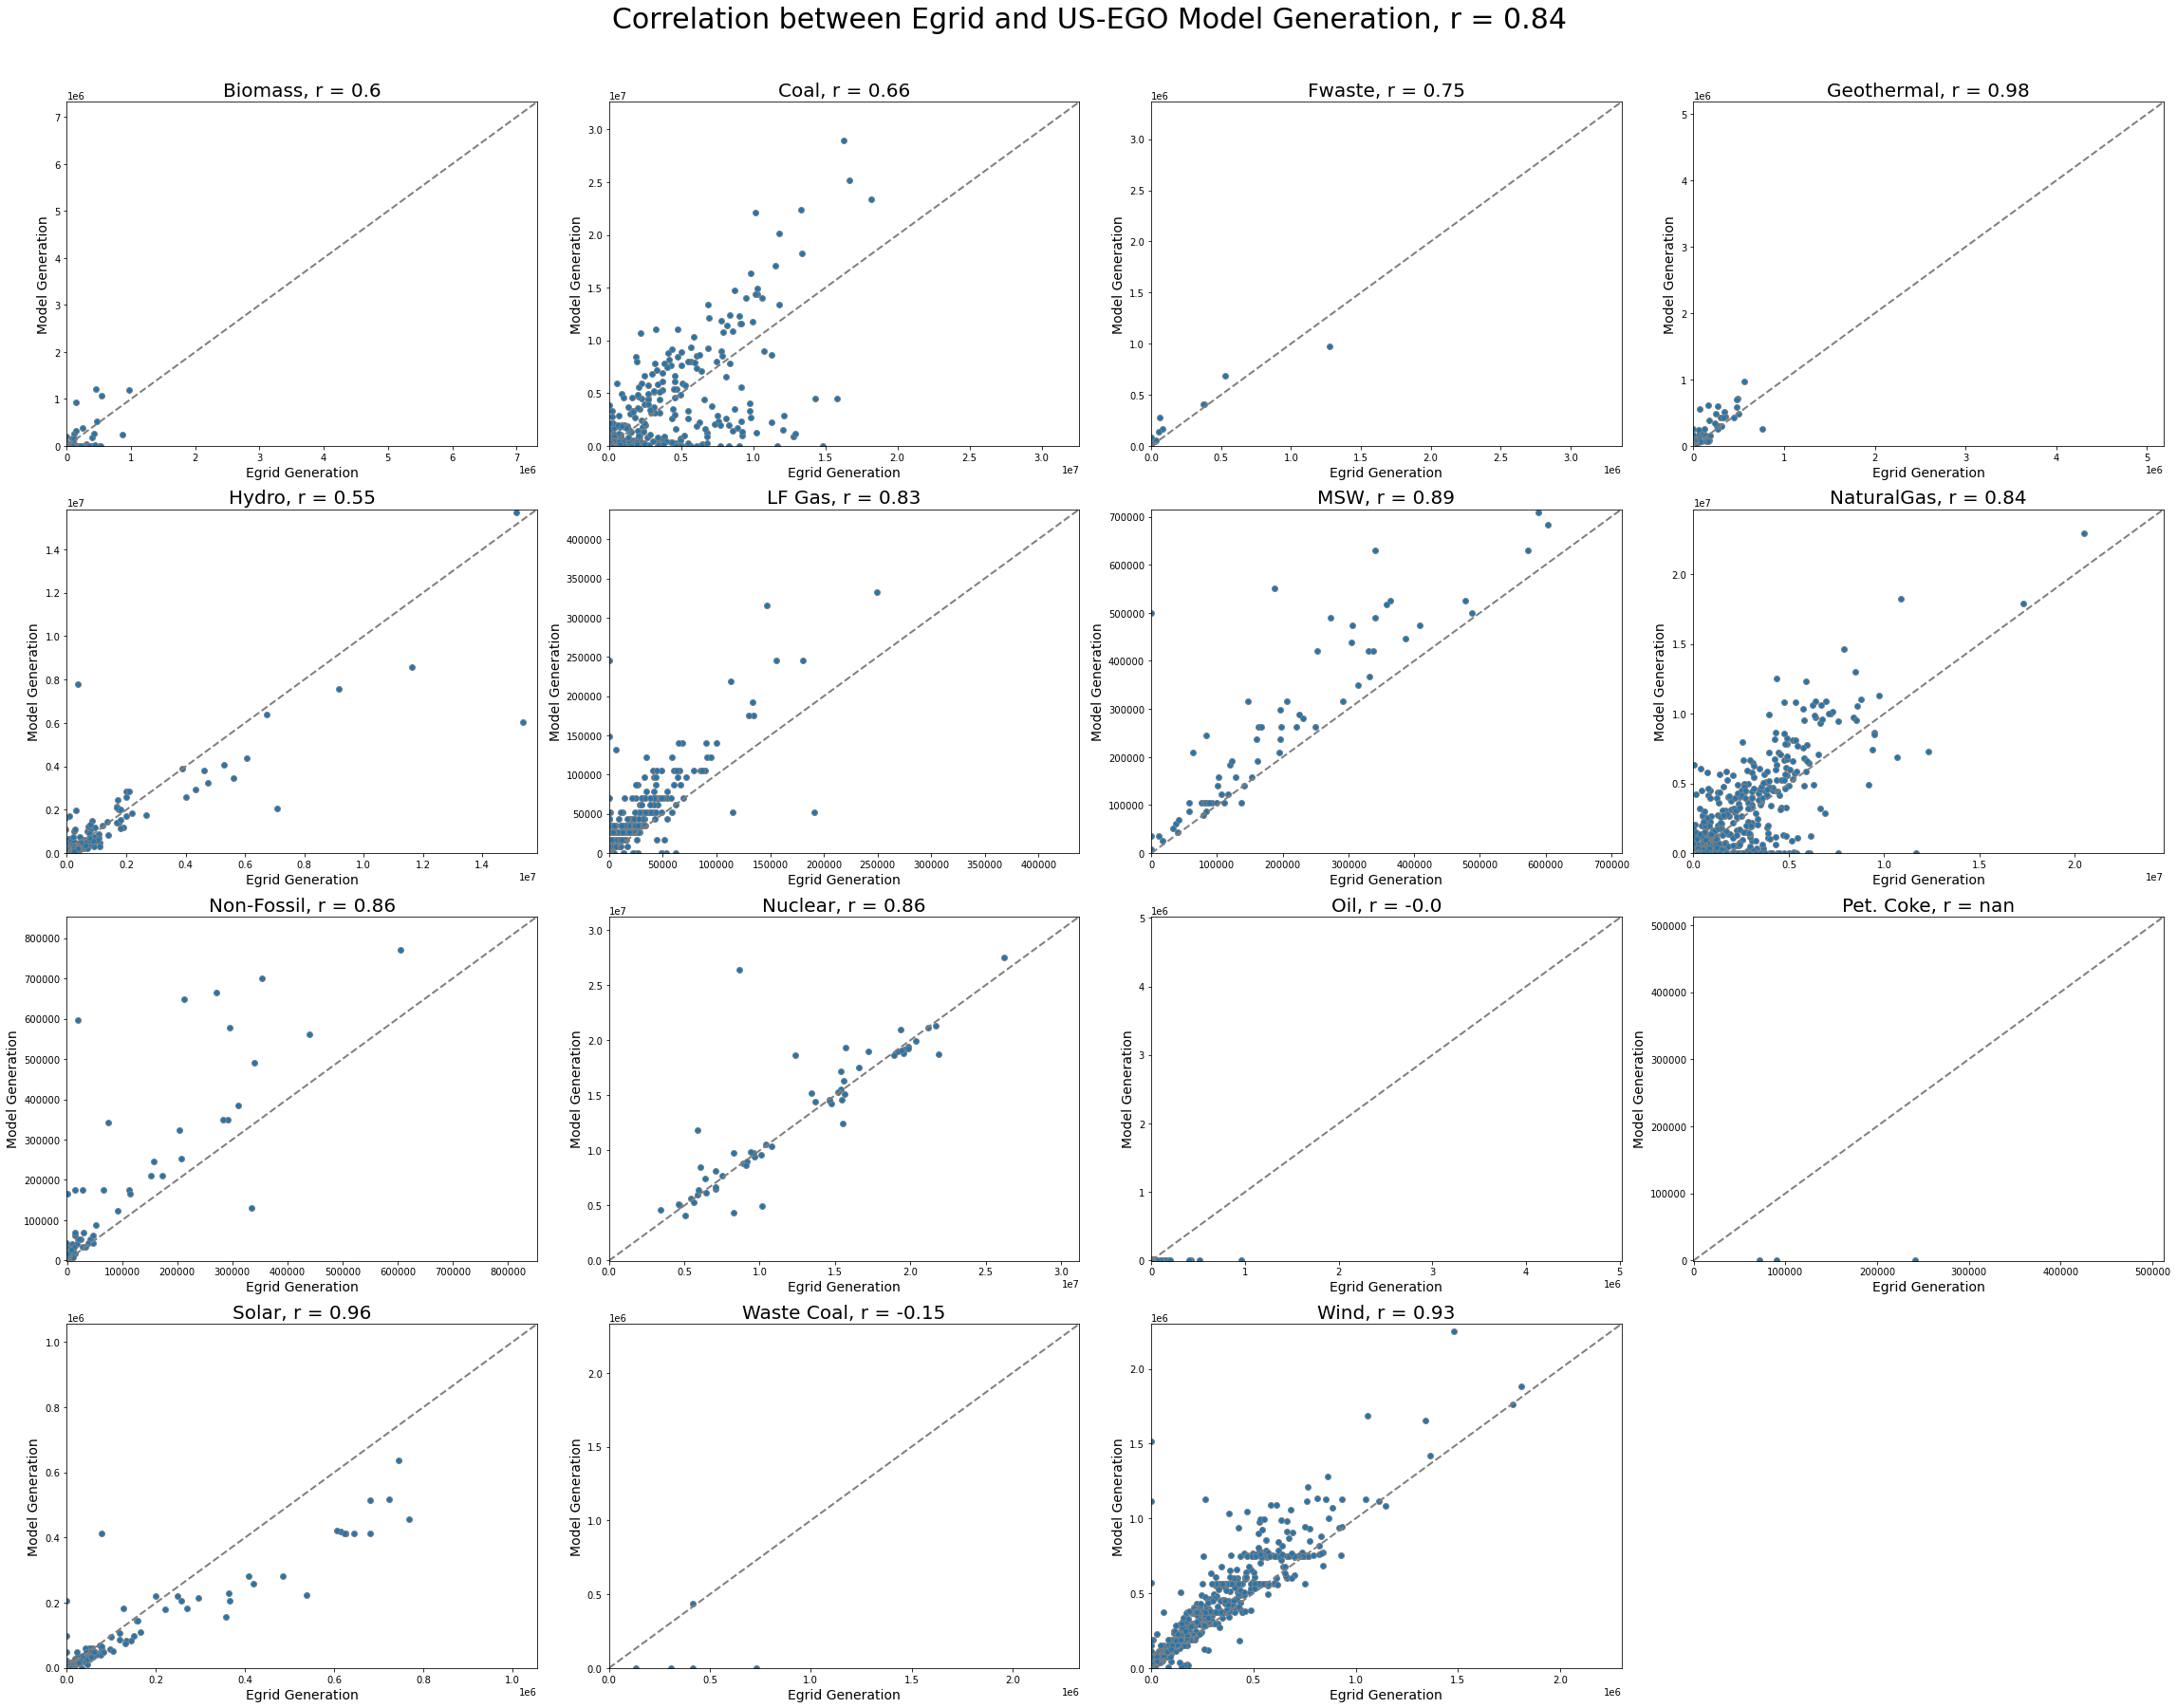

In [6]:
#find the correlation of coal production between 
source_list = ['Biomass', 'Coal', 'Fwaste', 'Geothermal', 'Hydro', 'LF Gas',
       'MSW', 'NaturalGas', 'Non-Fossil', 'Nuclear', 'Oil', 'Pet. Coke',
       'Solar', 'Waste Coal', 'Wind']
fig = plt.figure(figsize = [32,24])
for idx,src in enumerate(source_list):
    #make subplots
    ax = fig.add_subplot(4,4,idx+1)
    #plot a scatterplot
    ax = gmodel_egrid_ds.sel(model_name = 'normal').sel(ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src)).plot.scatter(
        x='annual_egridgeneration', 
        y='annual_modelgeneration', 
        c=normal_color, 
        marker='o', 
        edgecolors = 'C7')
    #create a max for the x and y lims
    MM = max(gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['annual_egridgeneration'].max(), 
             gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['annual_modelgeneration'].max())/1.2
    #plot 1:1 line
    plt.plot(np.arange(0, MM, 100), np.arange(0,MM, 100), '--C7', linewidth = 2)
    #calculate the correlation
    corr = np.round(gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['annual_modelgeneration'].to_pandas().corr(gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['annual_egridgeneration'].to_pandas()), 2)
    #modify labels and limits
    plt.xlabel('Egrid Generation', fontsize = 14)
    plt.ylabel('Model Generation', fontsize = 14)
    plt.xlim([-100, MM]);
    plt.ylim([-100, MM]);
    plt.title(f'{src}, r = {corr}', fontsize = 20)
    
    
plt.tight_layout()
plt.suptitle('Correlation between Egrid and US-EGO Model Generation, r = ' 
             + str(np.round(gmodel_egrid_ds.sel(model_name = 'normal')['annual_modelgeneration'].to_pandas().corr(gmodel_egrid_ds.sel(model_name = 'normal')['annual_egridgeneration'].to_pandas()), 2)), 
             fontsize = 30, y = 1.04);

# Generation by plant type and region name

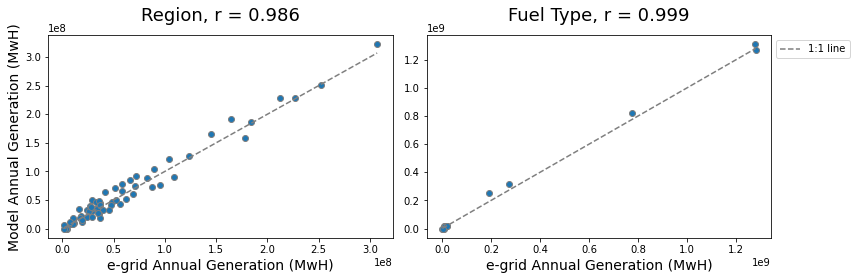

In [51]:
### plot scatter of region annual emissions vs egrid
fig, axes = plt.subplots(1,2, figsize = [12,4])
for idx, ds in enumerate([regionname_grouped_ds, fueltype_grouped_ds]):
    ax = axes[idx]
    
    #scatter plot
    x = ds.sel(model_name = 'normal')['annual_egridgeneration']
    y = ds.sel(model_name = 'normal')['annual_modelgeneration']
    ax.scatter(x.values, y.values, edgecolors = 'C7')
    
    #plot 1:1 line
    xlin = np.linspace(x.min(skipna=True),x.max(skipna=True),100)
    ax.plot(xlin, xlin, '--C7', label='1:1 line');
    
    #labels
    ax.set_xlabel('e-grid Annual Generation (MwH)', fontsize = 14)
    ax.set_title(ds.sel(model_name = 'normal').attrs['group'], fontsize = 20)
    ax.set_title(ds.sel(model_name = 'normal').attrs['group'] + ', r = ' 
             + str(np.round(ds.sel(model_name = 'normal')['annual_modelgeneration'].to_pandas().corr(ds.sel(model_name = 'normal')['annual_egridgeneration'].to_pandas()), 3)), 
             fontsize = 18, y = 1.04);
plt.legend(bbox_to_anchor = [1.0, 1.0])
axes[0].set_ylabel('Model Annual Generation (MwH)', fontsize = 14)
plt.tight_layout()
#plt.savefig('./Figures/egrid_model.png', bbox_inches = 'tight', dpi = 150)

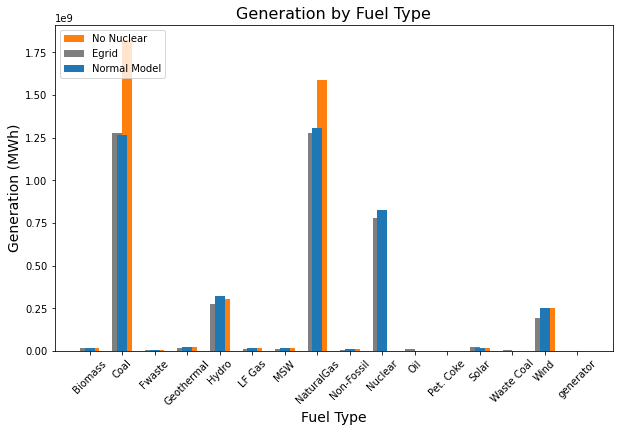

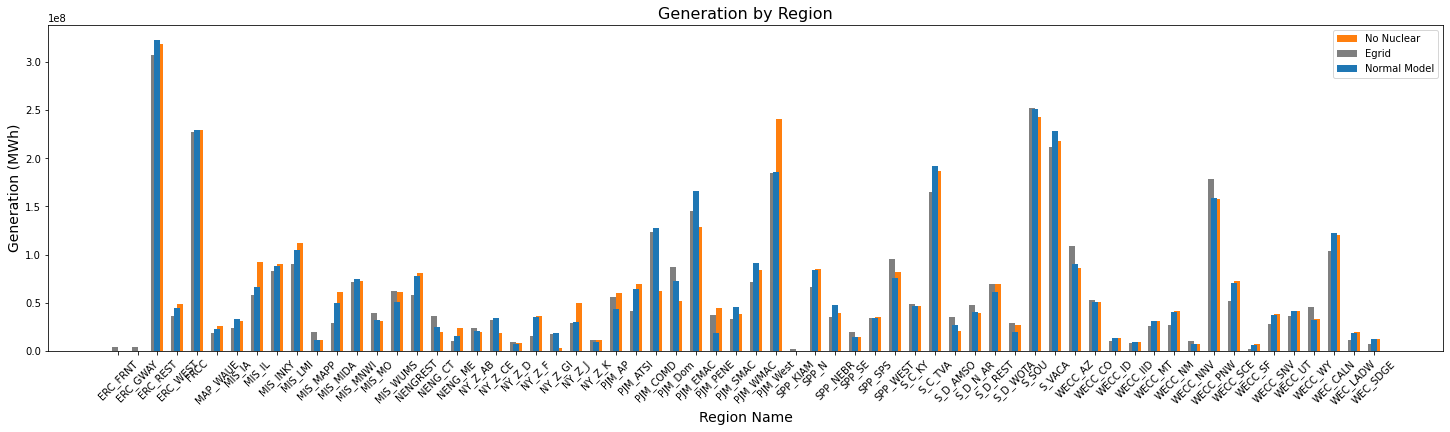

In [9]:
### plot all three egrid, nonuc, normal model generation by:

#fuel type
plotting.plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype', yvariable1 = 'annual_modelgeneration',egrid = True, egrid_yvariable = 'annual_egridgeneration', figsize = [10,6])
plt.xlabel('Fuel Type', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Generation by Fuel Type', fontsize = 16);
#plt.savefig('./Figures/fuel_type_all.png', dpi=300, bbox_inches = 'tight')

#region name
plotting.plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = True, yvariable1 = 'annual_modelgeneration', egrid_yvariable = 'annual_egridgeneration', figsize = [25,6])
plt.xlabel('Region Name', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Generation by Region', fontsize = 16);
#plt.savefig('./Figures/region_name_all.png', dpi=300, bbox_inches = 'tight')


# Emissions by region and fuel type

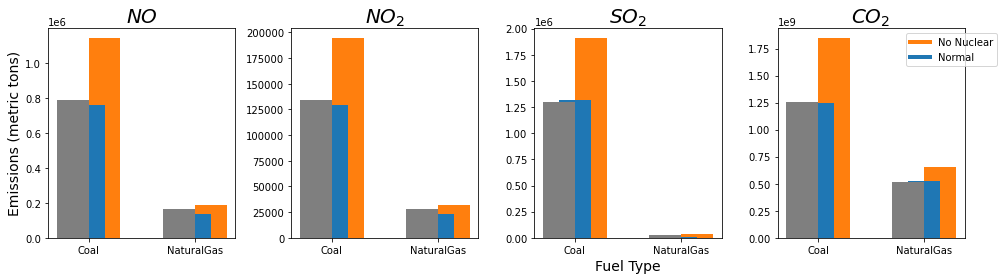

In [33]:
#plot by fuel type
plotting.fossil_fuel_plot(fueltype_grouped_ds, sci_names = sci_names, xvariable = 'fueltype', 
                          pollutants = ['NO','NO2','SO2','CO2'], figsize = [14,4],
                         nonuc_color = nonuc_color, normal_color = normal_color, egrid_color = egrid_color)
#plt.savefig('./Figures/emissions_fueltype.png', bbox_inches = 'tight', dpi = 150)

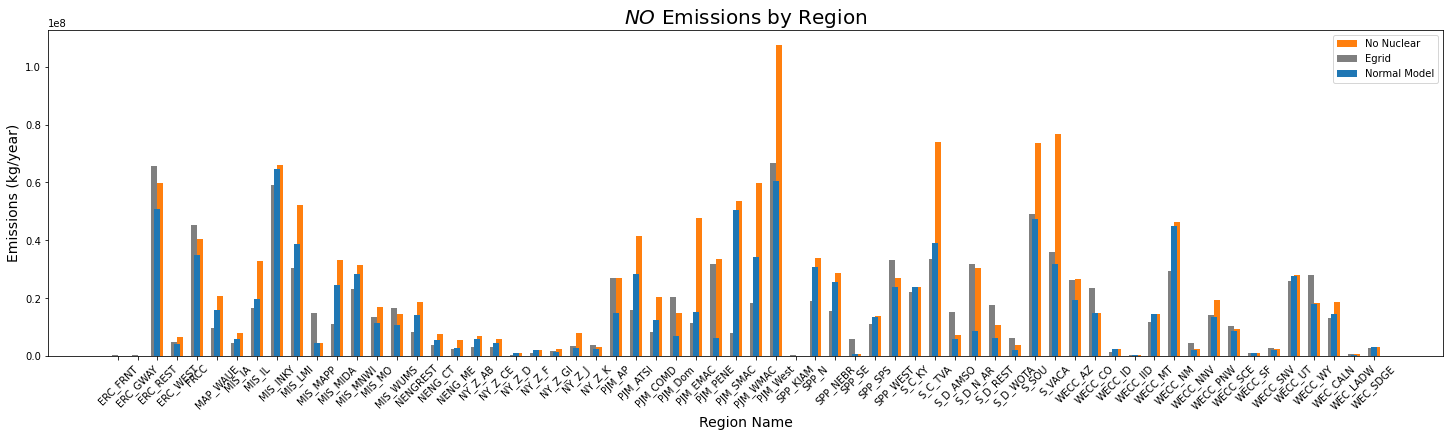

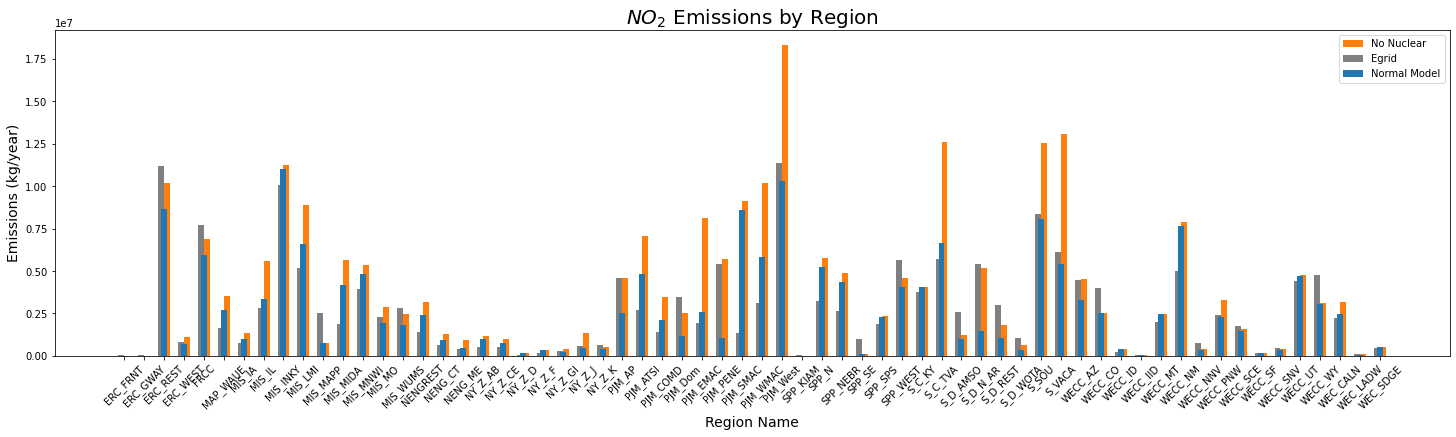

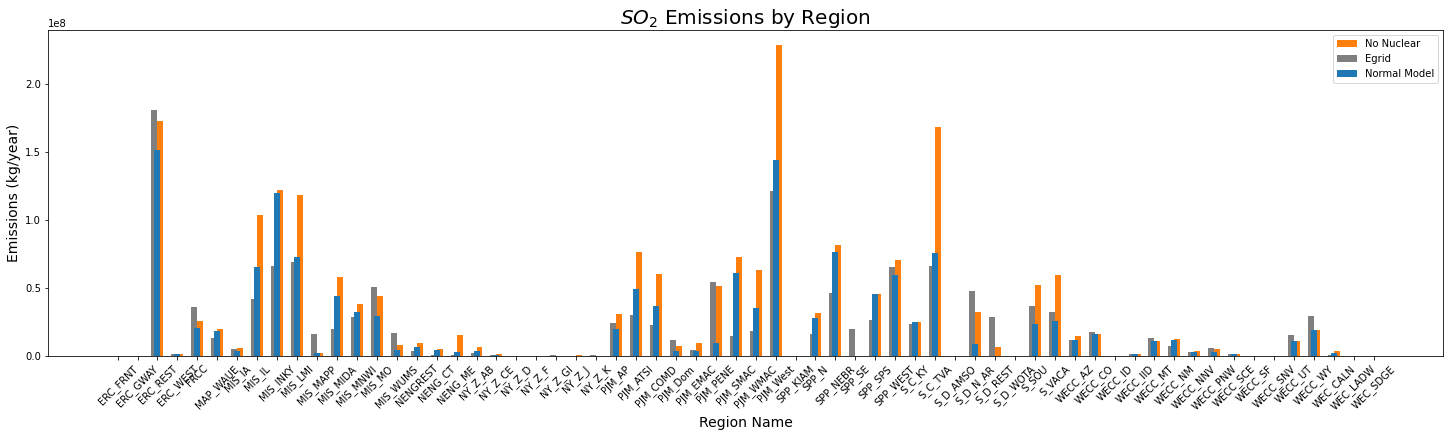

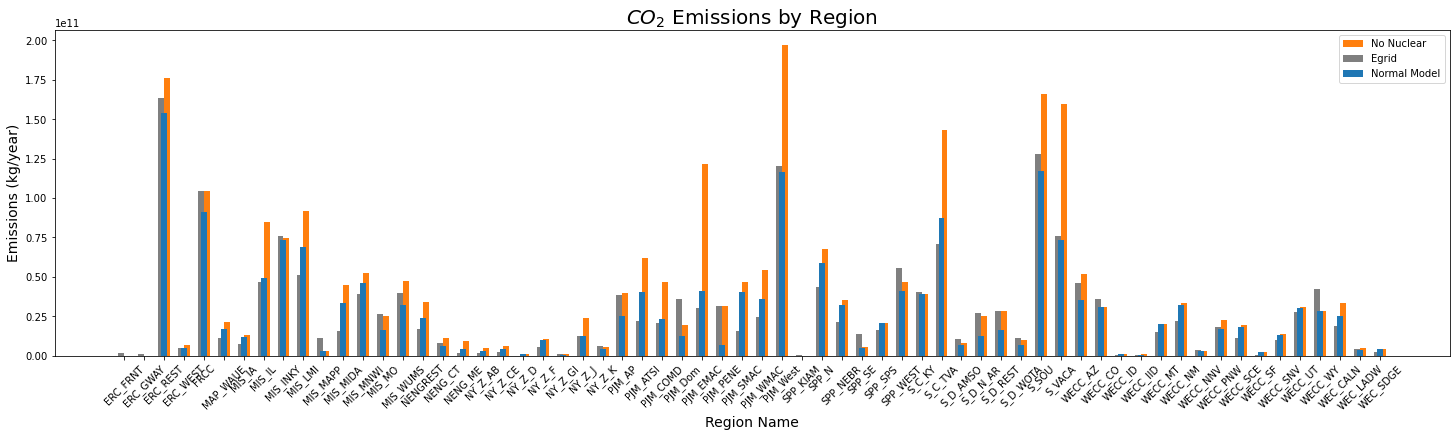

In [15]:
for pollutant in ['NO','NO2','SO2','CO2']:
    #plot by region
    plotting.plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = True, yvariable1 = f'model_annual_{pollutant}_conc', egrid_yvariable = f'egrid_annual_{pollutant}_conc', figsize = [25,6])
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'Emissions (kg/year)', fontsize = 14)
    plt.title(f'{sci_names[pollutant]} Emissions by Region', fontsize = 20);


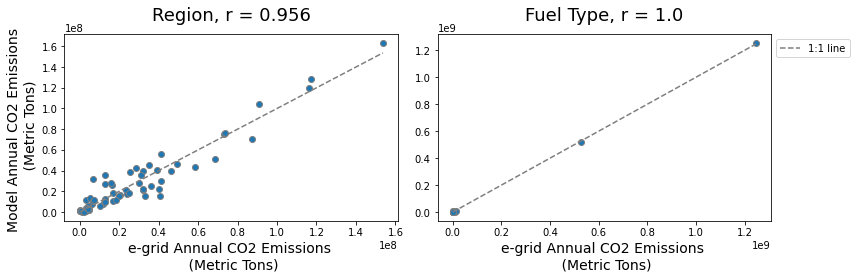

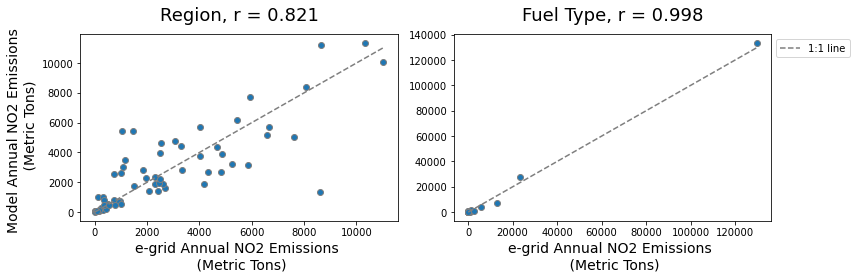

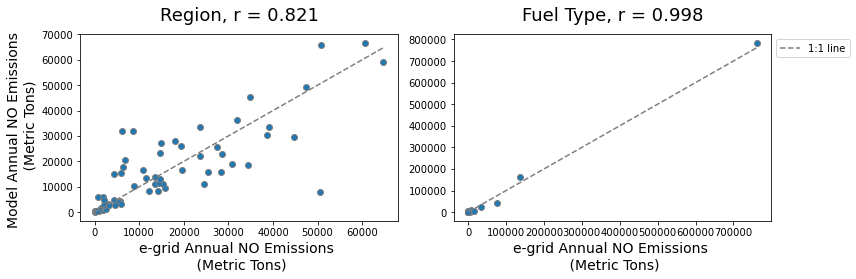

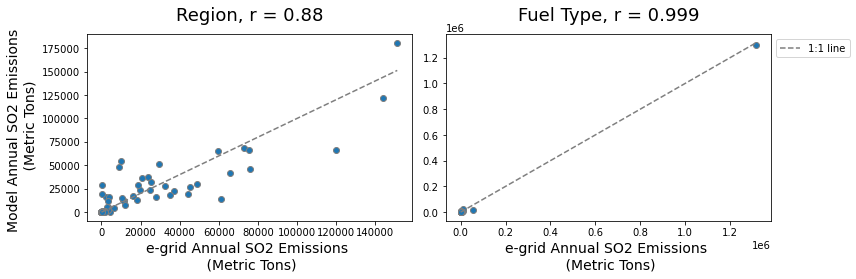

In [54]:
### plot scatter of region annual emissions vs egrid
for pollutant in ['CO2','NO2','NO','SO2']:
    fig, axes = plt.subplots(1,2, figsize = [12,4])
    for idx, ds in enumerate([regionname_grouped_ds, fueltype_grouped_ds]):
        ax = axes[idx]

        #scatter plot
        x = ds.sel(model_name = 'normal')[f'model_annual_{pollutant}_conc']/1000
        y = ds.sel(model_name = 'normal')[f'egrid_annual_{pollutant}_conc']/1000
        ax.scatter(x.values, y.values, edgecolors = 'C7')

        #plot 1:1 line
        xlin = np.linspace(x.min(skipna=True),x.max(skipna=True),100)
        ax.plot(xlin, xlin, '--C7', label='1:1 line');

        #labels
        ax.set_xlabel(f'e-grid Annual {pollutant} Emissions \n (Metric Tons)', fontsize = 14)
        ax.set_title(ds.sel(model_name = 'normal').attrs['group'] + ', r = ' 
             + str(np.round(ds.sel(model_name = 'normal')[f'model_annual_{pollutant}_conc'].to_pandas().corr(ds.sel(model_name = 'normal')[f'egrid_annual_{pollutant}_conc'].to_pandas()), 3)), 
             fontsize = 18, y = 1.04);

    plt.legend(bbox_to_anchor = [1.0, 1.0])
    axes[0].set_ylabel(f'Model Annual {pollutant} Emissions \n (Metric Tons)', fontsize = 14)
    plt.tight_layout()
    #plt.savefig('./Figures/egrid_model.png', bbox_inches = 'tight', dpi = 150)

## Percent Change in Pollutants

In [55]:
### make a percent change variable in pollutants
for pollutant in pollutants:
    fueltype_grouped_ds[f'{pollutant}_percent_change'] = 100* ((fueltype_grouped_ds.sel(model_name = 'nonuc')[f'model_annual_{pollutant}_conc'] - 
                                 fueltype_grouped_ds.sel(model_name = 'normal')[f'model_annual_{pollutant}_conc'])/fueltype_grouped_ds.sel(model_name = 'normal')[f'model_annual_{pollutant}_conc'])

In [56]:
for pollutant in ['NO','NO2','SO2','CO2']:
    print(f'Coal {pollutant} increase ' +
          str(fueltype_grouped_ds.sel(model_name = 'nonuc')[f'{pollutant}_percent_change'].sel(fueltype = 'Coal').values))
    print(f'Natural Gas {pollutant} increase ' +
          str(fueltype_grouped_ds.sel(model_name = 'nonuc')[f'{pollutant}_percent_change'].sel(fueltype = 'NaturalGas').values))

Coal NO increase 49.65318080562239
Natural Gas NO increase 39.59710998639438
Coal NO2 increase 49.65318080562228
Natural Gas NO2 increase 39.59710998639447
Coal SO2 increase 44.691446422187546
Natural Gas SO2 increase 205.50763022292915
Coal CO2 increase 47.918794298511344
Natural Gas CO2 increase 24.94924122542257


## Total Changes

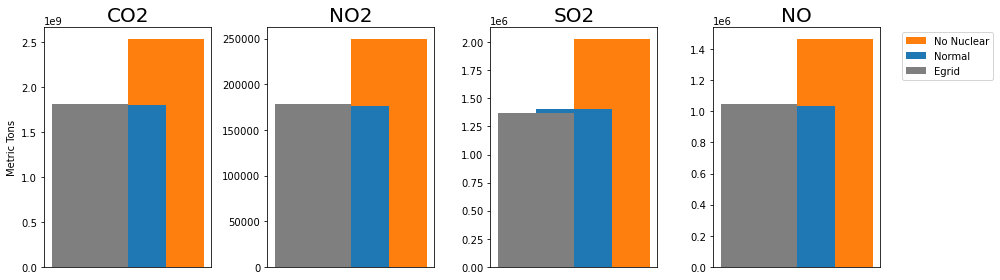

In [64]:
fig,axes = plt.subplots(1, 4, figsize=[14,4])
for idx_p, pollutant in enumerate(['CO2','NO2','SO2','NO']):
    ax = axes[idx_p]
    ax.bar(pollutant, gmodel_egrid_ds.sel(model_name = 'nonuc')[f'model_annual_{pollutant}_conc'].sum().values/1000, color = nonuc_color, width = .3, align = 'edge', label = 'No Nuclear')
    ax.bar(pollutant, gmodel_egrid_ds.sel(model_name = 'normal')[f'model_annual_{pollutant}_conc'].sum().values/1000, color = normal_color, width = .3, label = 'Normal')
    ax.bar(pollutant, gmodel_egrid_ds.sel(model_name = 'normal')[f'egrid_annual_{pollutant}_conc'].sum().values/1000, color = egrid_color, width = -.3, align = 'edge', label = 'Egrid')
    ax.set_title(pollutant, fontsize = 20)
    ax.tick_params(axis = "x", which = "both", bottom = False, labelbottom = False)
axes[0].set_ylabel('Metric Tons')
plt.legend(bbox_to_anchor = [1.1, 1.0])
plt.tight_layout();
#plt.savefig('CO2_dif.png', )

In [76]:
gmodel_egrid_ds.sel(model_name = 'nonuc')[f'model_annual_CO2_conc'].sum().values/1000

2534187458.215548

In [75]:
gmodel_egrid_ds.sel(model_name = 'normal')[f'model_annual_CO2_conc'].sum().values/1000

1801902757.3860316